In [41]:
pip install seaborn --upgrade
!pip install langdetect

     |████████████████████████████████| 293 kB 42.0 MB/s            
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.1
    Uninstalling seaborn-0.10.1:
      Successfully uninstalled seaborn-0.10.1
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [25]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import itertools



from string import punctuation
from langdetect import detect, DetectorFactory, LangDetectException
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

My dataset I have chosen to work it is a set containing books and their reviews. The data comes via the Goodreads API (https://www.goodreads.com/api). The training set is aproximately 54,000 books, and the test set is aproximately 1100 books. I intend to try and use tf-idf and NMF to predict reviews of my test data set.

## EDA

In [3]:
# create dataframes of training and test data sets
train = pd.read_csv('book_data.csv')
test = pd.read_csv('test_book_data.csv')

print(train.info)

print(train.isnull().sum())
print(test.isnull().sum())

<bound method DataFrame.info of                                             book_authors  \
0                                        Suzanne Collins   
1                             J.K. Rowling|Mary GrandPré   
2                                             Harper Lee   
3      Jane Austen|Anna Quindlen|Mrs. Oliphant|George...   
4                                        Stephenie Meyer   
...                                                  ...   
54296                                      Howard Megdal   
54297                                      Howard Megdal   
54298                                      Howard Megdal   
54299                             Mimi Baird|Eve Claxton   
54300                                         Leah Price   

                                               book_desc  \
0      Winning will make you famous. Losing means cer...   
1      There is a door at the end of a silent corrido...   
2      The unforgettable novel of a childhood in a sl...   
3      

It's clear I have many unnecessary columns, and many null values to work with. Since I have so many items in the dataset, I will just remove null values. The only columns that will be relevant to me are the book_desc and book_rating columns, since I will be running tf-idf on the description and trying to model the rating from that.

In [4]:
train = train[['book_desc', 'book_rating']].copy()
test = test[['book_desc', 'book_rating']].copy()

train = train.replace(r'^\s*$', np.nan, regex=True) # replacing any blank cells with np.nan
train = train.dropna()

print(train)
print(train.isnull().sum())

                                               book_desc  book_rating
0      Winning will make you famous. Losing means cer...         4.33
1      There is a door at the end of a silent corrido...         4.48
2      The unforgettable novel of a childhood in a sl...         4.27
3      «È cosa ormai risaputa che a uno scapolo in po...         4.25
4      About three things I was absolutely positive.F...         3.58
...                                                  ...          ...
54295  Avi Steinberg is stumped. After defecting from...         3.51
54296  In this fearless and half-crazy story, Howard ...         3.37
54297  From the icons of the game to the players who ...         3.97
54299  Soon to be a major motion picture, from Brad P...         3.82
54300  The Anthology and the Rise of the Novel brings...         3.58

[52969 rows x 2 columns]
book_desc      0
book_rating    0
dtype: int64


In [5]:
# same cleaning on test set
test = test.replace(r'^\s*$', np.nan, regex=True)
test = test.dropna()

Further inspection of the dataset shows that many of the descriptions are not in english, and many have strange characters or html tags that need to be removed before moving on.

In [6]:
train['book_desc'][770]

'\r\r\r\r\r\r\r\r\n“We were all heading for each other on a collision course, no matter what. Maybe some people are just meant to be in the same story.”\r\r\r\r\r\r\r\r\n At first, Jude and her twin brother Noah, are inseparable. Noah draws constantly and is falling in love with the charismatic boy next door, while daredevil Jude wears red-red lipstick, cliff-dives, and does all the talking for both of them. Years later, they are barely speaking. Something has happened to change the twins in different yet equally devastating ways . . . but then Jude meets an intriguing, irresistible boy and a mysterious new mentor. The early years are Noah’s to tell; the later years are Jude’s. But they each have only half the story, and if they can only find their way back to one another, they’ll have a chance to remake their world. This radiant, award-winning novel from the acclaimed author of The Sky Is Everywhere will leave you breathless and teary and laughing—often all at once. Printz Award Winne

In [7]:
train['book_desc'][33397]

'প্রথম যুগের উদয়দিঙ্গনে\xa0\xa0\xa0\xa0\xa0প্রথম দিনের উষা নেমে এল যবেপ্রকাশপিয়াসি ধরিত্রী বনে বনে\xa0\xa0\xa0\xa0\xa0শুধায়ে ফিরিল সুর খুঁজে পাবে কবে।।এসো এসো সেই নবসৃষ্টির কবিনবজাগরণযুগপ্রভাতের রবি―গান এনেছিলে নব ছন্দের তালেতরুণী উষার শিশিরস্নানের কালে\xa0\xa0\xa0\xa0\xa0আলো-আঁধারের আনন্দবিপ্লবে।।সে গান আজিও নানা রাগরাগিণীতেশুনাও তাহারে আগমনিসঙ্গিতে\xa0\xa0\xa0\xa0\xa0যে জাগায় চোখে নূতন-দেখার দেখা।যে এসে দাঁড়ায় ব্যাকুলিত ধরণীতেবননীলিমার পেলব সীমানাটিতে,\xa0\xa0\xa0\xa0\xa0বহু জনতার মাঝে অপূর্ব একা।অবাক্ আলোযর লিপি যে বহিয়া আনেনিভৃত প্রহরে কবির চকিত প্রাণে,\xa0\xa0\xa0\xa0\xa0বিহ্বল প্রাতে সঙ্গীতসৌরভে\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0দূর আকাশের অরুণিম উত্সবে।।'

In [8]:
# creating methods to clean the text

def clean_text(text):
    #simplifiy the text, remove punctuation and tags
    text = text.lower().split()

    text = " ".join(text)

    text = re.sub(r"<br />", " ", text)
    text = re.sub(r"[^a-z]", " ", text)
    text = re.sub(r"   ", " ", text)  #
    text = re.sub(r"  ", " ", text)

    text = ''.join([c for c in text if c not in punctuation]) 

    return text

def lang_check(text):
    #lang_check will check the language, and replace the text with np.nan if it is not english, allowing for easy removal
    DetectorFactory.seed = 0

    try:
        lang = detect(text)
    except(RuntimeError, TypeError, NameError, LangDetectException): #if language cannot be identified, dummy language 'zz'
        lang = 'zz'

    if lang == 'en':
        text = text
    else:
        text = np.nan

    return text


In [9]:
# training data cleaning

# checking the language of each book_desc
train_lang = []
for desc in train.book_desc:
    train_lang.append(lang_check(desc))

# adding column to the train df called text which has all of the book descriptions that were english
train['text'] = train_lang
train = train.dropna()

# cleaning book_desc text
train_clean = []
for text in train.text:
    train_clean.append(clean_text(text))

# replacing 'text' column with newly cleaning text
train['text'] = train_clean
train = train.drop('book_desc', axis=1)

# once again replacing blank cells with np.nan just to be safe, then dropping all np.nan
train = train.replace(r'^\s*$', np.nan, regex=True)
train = train.dropna()

# Same procedure for test data cleaning
test_lang = []
for desc in test.book_desc:
    test_lang.append(lang_check(desc))

test['text'] = test_lang
test = test.dropna()

test_clean = []
for text in test.text:
    test_clean.append(clean_text(text))

test['text'] = test_clean
test = test.drop('book_desc', axis=1)

test = test.replace(r'^\s*$', np.nan, regex=True)
test = test.dropna()

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46019 entries, 0 to 54300
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   book_rating  46019 non-null  float64
 1   text         46019 non-null  object 
dtypes: float64(1), object(1)
memory usage: 1.1+ MB


Data cleaning removed about 6000 entries from the dataset. Still, with 46,000 items, splitting the data will be necessary to make it more manageable.

In [11]:
# checking the book rating column out
train.book_rating

0        4.33
1        4.48
2        4.27
4        3.58
5        4.36
         ... 
54295    3.51
54296    3.37
54297    3.97
54299    3.82
54300    3.58
Name: book_rating, Length: 46019, dtype: float64

Rather than floats, I want to have these numbers rounded to int so I can more easily predict them

In [12]:
train.book_rating = train.book_rating.round()
test.book_rating = test.book_rating.round() # same thing for test data

train = train.astype({'book_rating': int})
test = test.astype({'book_rating': int})

train.book_rating

0        4
1        4
2        4
4        4
5        4
        ..
54295    4
54296    3
54297    4
54299    4
54300    4
Name: book_rating, Length: 46019, dtype: int64

Much better. Now let's visualize the data some

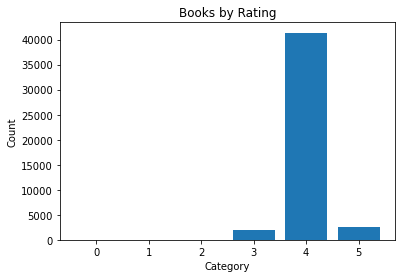

4    41376
5     2543
3     2024
0       58
2       18
Name: book_rating, dtype: int64


In [13]:
uniq_cat = train['book_rating'].unique()

value_counts = train['book_rating'].value_counts()
plt.bar(uniq_cat, value_counts)
plt.title("Books by Rating")
plt.ylabel("Count")
plt.xlabel("Category")
plt.show()

print(value_counts)

Since the vast majority of ratings are  4s, they will dominate the ratings. I will drop 0s and 2s, and reduce the number of 4s, so that we have a nice even distribution of ratings.

In [14]:
train_4 = train.drop(train[train['book_rating'] < 4].index)
train_4 = train_4.drop(train_4[train_4['book_rating'] > 4].index)

train = train.drop(train[train['book_rating'] < 3].index)
train = train.drop(train[train['book_rating'] == 4].index)

train_4, excess_train_4 = train_test_split(train_4, test_size=.95, random_state=0)

train = pd.concat([train, train_4], ignore_index=True)

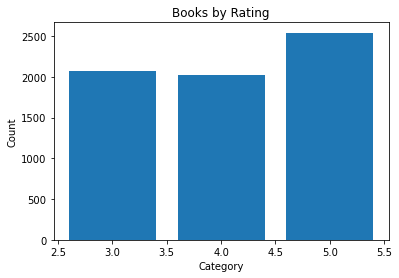

5    2543
4    2068
3    2024
Name: book_rating, dtype: int64


In [15]:
uniq_cat = train['book_rating'].unique()

value_counts = train['book_rating'].value_counts()
plt.bar(uniq_cat, value_counts)
plt.title("Books by Rating")
plt.ylabel("Count")
plt.xlabel("Category")
plt.show()

print(value_counts)

Now we have a fairly even distribution of ratings. Let's take a look at the book descriptions themselves

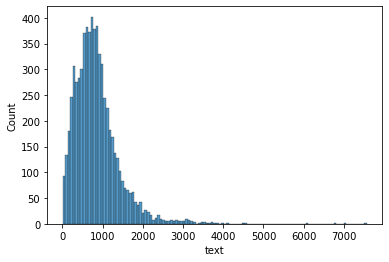

In [16]:
word_count = train['text'].str.len()
sns.histplot(word_count)

A fairly nice disribution of length of descriptions. The very long descriptions could heavily influence the model, but this can be accounted for in the tf-idf with the sublinear_tf parameter, so I will not worry about them now

I will use sklearns TfidfVectorizer to process the raw text. It stands for term frequency-inverse document frequency. It works by basically counting how frequently words or phrases appear in documents, and how many documents contain those words or phrases. By multiplying the term frequency by the inverse document frequency, you end up with a matrix where each row is a document, and each column is a word or phrase, and the cells are the tf-idf score. This matrix will be used in NMF later on.

In [17]:
# vectorize the text in each article
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=15, norm='l2', ngram_range=(1, 1), stop_words='english')
train_features = tfidf.fit_transform(train.text).toarray()
test_features = tfidf.transform(test.text).toarray()

labels = train.book_rating

Visualizing the tfidf in 2d with the help of TSNE

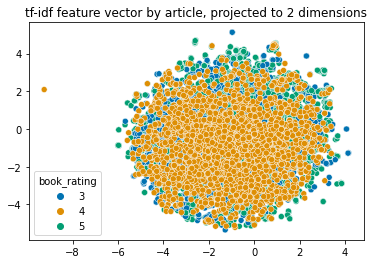

In [18]:
#project data to 2D
tsne_features = TSNE().fit_transform(train_features)
sns.scatterplot(x=tsne_features[:,0], y=tsne_features[:,1], hue=labels,
                palette='colorblind').set(title='tf-idf feature vector by article, projected to 2 dimensions')
plt.show()

Not showing a great result. We are looking to see a nice separation between our three categories, but we have a big blob. I tried adjusting many of the parameters in the tf-idf, but I could not get a good separation. This leads me to believe that our NMF will struggle to produce accurate ratings, but we will push on and see what happens.

## Analysis with Unsupervised Learning

Building some methods that will help make the optimization of my model easier

In [19]:
# NMF model will take our train_factors matrix and decompose it to a factor matrix we can use to make predictions from
def NMFmodel(solver, beta_loss, features, init=None):
    model = NMF(n_components=3, solver=solver, beta_loss=beta_loss, init=init, random_state=0)
    W = model.fit_transform(features)

    return model, W

def predict(categories, transform):
    yp = []
    W = pd.DataFrame(transform)

    id2cat = {index: element for index, element in enumerate(categories)}

    for row in range(len(W.index)):
        pred = W.loc[row].idxmax()
        pred = id2cat.get(pred)
        yp.append(pred)

    return yp


def label_permute_compare(yt, W):
    """
    yt: y_true
    W the basis matrix of the current model
    label_permute_compare runs through the permutations of the 3 ratings, and runs the predictions for that iteration
    then calculates the accuracy with given predictions, and stores the best results
    """
    max_score = 0
    order = []
    iterations = list(itertools.permutations(range(3, 6)))

    for i in iterations:
        categories = i
        yp = predict(categories, W)
        score = accuracy_score(yt, yp)
        if score > max_score:
            max_score = score
            order = i

    return order, max_score


In [21]:
initialNMF, initialW = NMFmodel('cd', 'frobenius', train_features)

# find correct order of categories
categories, acc = label_permute_compare(labels, initialW)

yp = predict(categories, initialW)
acc = accuracy_score(labels, yp)

print(acc)

0.41220798794272795


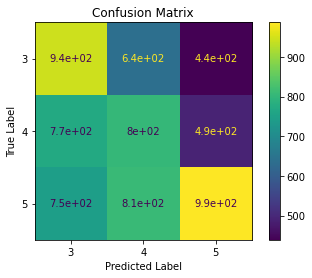

In [22]:
# confusion matrix
cm = confusion_matrix(labels, yp)

color = 'white'
matrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(uniq_cat))
matrix.plot()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

41% accuracy it not great for only predicting a range of 3-5. Did predict about 50% of the 3 ratings accurately, if we are trying to look on the bright side. Trying to optimize the model now.

In [23]:
# hyperparameter tuning
# lists for comparison
attempted_model = []
train_accuracy = []

attempted_model.append('Initial')
train_accuracy.append(acc)

# trying to optimize #
mu_solver, mu_solver_W = NMFmodel('mu', 'frobenius', train_features)

yp = predict(categories, mu_solver_W)
acc = accuracy_score(labels, yp)

attempted_model.append('mu Solver')
train_accuracy.append(acc)

# trying to optimize #
KL_beta_loss, KL_beta_loss_W = NMFmodel('mu', 'kullback-leibler', train_features)

yp = predict(categories, KL_beta_loss_W)
acc = accuracy_score(labels, yp)

attempted_model.append('KL beta-loss')
train_accuracy.append(acc)

# trying to optimize #
random_init, random_init_W = NMFmodel('mu', 'kullback-leibler', train_features, 'random')

yp = predict(categories, random_init_W)
acc = accuracy_score(labels, yp)

attempted_model.append('Random Init')
train_accuracy.append(acc)


print(attempted_model, train_accuracy)

['Initial', 'mu Solver', 'KL beta-loss', 'Random Init'] [0.41220798794272795, 0.412810851544838, 0.4105501130369254, 0.4076865109269028]


All of the models produced similar results, but the best performer for this case was using the mu solver. Trying that model on the test data.

In [28]:
mu_solver, mu_solver_W = NMFmodel('mu', 'frobenius', test_features)
test_labels = test.book_rating

yp = predict(categories, mu_solver_W)
acc = accuracy_score(test_labels, yp)

print(acc)

0.20707964601769913


Yikes, worse than a random guess

In [31]:
import random
randomlist = []
for i in range(0,1130):
    n = random.randint(3,5)
    randomlist.append(n)

yp = randomlist
acc = accuracy_score(test_labels, yp)

print(acc)

0.3407079646017699


Trying a supervised approach 

In [34]:
# Supervised Learning #

model = LogisticRegression(random_state=0)
model.fit(train_features, labels)
y_pred = model.predict(train_features)
acc = accuracy_score(labels, y_pred)

print(acc)

0.8227581009796534


## Conclusion

Logistic regression performed MUCH better than NMF for this dataset, with no optimization. In retrospect, this data may not have been a great choice for an unsupervised learning approach. Because the text I am analyzing it just a description of the book, and not an actual review of the book, many of the descriptions could have been very similar for different reviews, leading to very noisy data. NMF is succeptible to noisy data, whereas logistic regression is less succeptible to noisy data, which could help explain why it performed so much better.

Find my report and data on github at https://github.com/crops004/DTSA-5510/